In [1]:
import pandas as pd

In [2]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [3]:
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

In [4]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 5

##Load data

In [5]:
train = pd.read_csv('../Data/train_modified_0229.csv')
test = pd.read_csv('../Data/test_modified_0229.csv')

In [9]:
target='NewGameFanPTs'
IDcol = 'Player_ID'

## General function

In [14]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=3, early_stopping_rounds=50):    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,\
                          early_stopping_rounds=early_stopping_rounds, show_progress=True)
        alg.set_params(n_estimators=cvresult.shape[0])
        print "number of estomators : "+ str(cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
        
    #Print model report:
#    print "\nModel Report"
#    print "Mean squared error(Train) : %.4g" % metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)
#    print "R^2 Score (Train): %f" % metrics.r2_score(dtrain[target], dtrain_predictions)
    
#     Predict on testing data:
#    test_result = alg.predict(dtest[predictors])
#    print "Mean squared error(Test) : %.4g" % metrics.mean_squared_error(dtest[target].values, test_result)
#    print 'R^2 Score (Test): %f' % metrics.r2_score(dtest[target], test_result)
                
#    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#    feat_imp[:30].plot(kind='barh', title='Feature Importances')
#    plt.ylabel('Feature Importance Score')
#    plt.show()
    return alg,dtrain_predictions

## Baseline model

In [15]:
predictors = [x for x in train.columns if x not in [target, IDcol, 'fullName']]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=6,
        min_child_weight=2,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'reg:linear',
        nthread=-1,
        scale_pos_weight=1,
        seed=27)

In [16]:
model1,train_predictions = modelfit(xgb1, train, test, predictors)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-rmse:22.019397+0.219011220646	cv-train-rmse:22.0011613333+0.0946164130699
[1]	cv-test-rmse:20.24182+0.229812932117	cv-train-rmse:20.198187+0.0892313946097
[2]	cv-test-rmse:18.6655796667+0.237346848896	cv-train-rmse:18.5974006667+0.0822302726102
[3]	cv-test-rmse:17.283274+0.249630283965	cv-train-rmse:17.1919853333+0.0740029485103
[4]	cv-test-rmse:16.079216+0.247706009585	cv-train-rmse:15.959872+0.0726598898017
[5]	cv-test-rmse:15.0314256667+0.248075113541	cv-train-rmse:14.8770246667+0.0733574356165
[6]	cv-test-rmse:14.1229416667+0.247108809423	cv-train-rmse:13.9335576667+0.0688601499966
[7]	cv-test-rmse:13.3382466667+0.248819931506	cv-train-rmse:13.1112746667+0.0635088768826
[8]	cv-test-rmse:12.661054+0.250315539514	cv-train-rmse:12.3934063333+0.0569767633124
[9]	cv-test-rmse:12.092124+0.241322688798	cv-train-rmse:11.7784783333+0.054101486026
[10]	cv-test-rmse:11.6043436667+0.240638610603	cv-train-rmse:11.2511363333+0.

number of estomators : 48


Stopping. Best iteration: 47


In [26]:
from ggplot import *

In [42]:
def plot_predictions(pred_label,data):     
    plot_obj = ggplot(aes(x='NewGameFanPTs', y=pred_label, colour='Rank'), data=data)+geom_point()+\
    ggtitle(pred_label+" Prediction Performance")+theme(axis_text_x  = element_text(angle = 60, hjust = 1))
    return(plot_obj)

In [44]:
with open('../Data/xgboost_model1.pickle', 'wb') as handle:
  pickle.dump((model1,train_predictions),handle)

In [24]:
train['train_predict'] = train_predictions

In [31]:
import pickle
with open('../Data/train_set_02_29.pickle', 'rb') as handle:
  train_set = pickle.load(handle)

In [36]:
train['Rank'] = train_set['Rank'].values

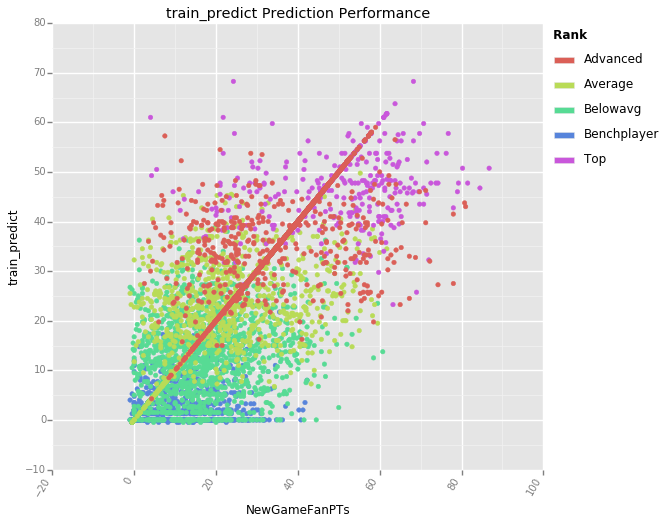

<ggplot: (285382093)>

In [43]:
plot_predictions('train_predict',train)

##XGBoosting Implementation

##Hyperparameters tuning

##Insights